In [1]:
%pylab nbagg
from tvb.simulator.lab import *
from sklearn.ensemble import ExtraTreesRegressor
import operator
from scipy.signal import butter, lfilter
import scipy

import pickle
import copy
import os

Populating the interactive namespace from numpy and matplotlib


In [191]:
datapath = 'data/'
savepath = 'fqi_test/'
datatime = 10000
len_frame = 100
dt = 1
n_frame = len_frame / dt
ic_buffer = 3000
runtime = 20000
action_weight = 0.2

#Import Test Data
Get the test data from the files in datapath

In [156]:
paths = os.listdir(datapath)
data_all = []

In [157]:
for path in paths:
    name_len = len(path)
    if path[name_len-2:name_len] == '.p':
        readfile = open(datapath + path, 'r')
        print path
        data_trial = pickle.load(readfile)
        readfile.close
        data_all.append(data_trial)

non.p
sin-amp100prd10cb1.p
sin-amp100prd25cb1.p
sin-amp100prd50cb1.p
sin-amp100prd5cb1.p
sin-amp10prd10cb1.p
sin-amp10prd25cb1.p
sin-amp10prd5cb1.p
sin-amp150prd25cb1.p
sin-amp150prd50cb1.p
sin-amp200prd25cb1.p
sin-amp200prd50cb1.p
sin-amp20prd25cb1.p
sin-amp25prd10cb1.p
sin-amp25prd5cb1.p
sin-amp30prd25cb1.p
sin-amp40prd25cb1.p
sin-amp50prd10cb1.p
sin-amp50prd25cb1.p
sin-amp50prd50cb1.p
sin-amp50prd5cb1.p
sqr-amp100prd10cb1pw10.p
sqr-amp100prd2cb1pw2.p
sqr-amp100prd4cb1pw2.p
sqr-amp100prd4cb1pw4.p
sqr-amp100prd50cb1pw10.p
sqr-amp100prd50cb1pw2.p
sqr-amp150prd10cb1pw10.p
sqr-amp150prd2cb1pw2.p
sqr-amp150prd4cb1pw2.p
sqr-amp150prd4cb1pw4.p
sqr-amp150prd50cb1pw10.p
sqr-amp150prd50cb1pw2.p
sqr-amp200prd50cb1pw10.p
sqr-amp200prd50cb1pw2.p
sqr-amp50prd10cb1pw10.p
sqr-amp50prd2cb1pw2.p
sqr-amp50prd4cb1pw2.p
sqr-amp50prd4cb1pw4.p


In [158]:
#sketchy fix!
for i in range(len(data_all)):
    if data_all[i][3][0] == 'non':
        data_all[i] = (data_all[i][0], data_all[i][1], data_all[i][2], ('non', ))

#State and Reward Extraction
    Look at state t - 1

    Decide action for state t

    Look at state t + 1 for reward (if it is not under stimulus)

In [159]:
#Assume dt = 1!
def analyze_frame(d_frame, prev_frames = []):
    
    avg = sum(d_frame) / float(len(d_frame))    
    
    if avg < 0:
        state_vector = (-1, )

    else:
        state_vector = (1, )
    
    

    return state_vector

In [160]:
#fuck... there is no action list, so i'm just gonna hardcode the action list from the data gen file
def trial_to_states(d_trial, action, alpha = 0.9, l = 0.2, h = 0.5, ordr = 4):
    prevlfp, rew = reward_frame(d_trial[0:len_frame], 0)
    
    prevlfp = 0
    rews = []
    states = []
    acts = []
    
    for i in range(len(d_trial) / len_frame):
        start = i * len_frame
        end = (i+1) * len_frame
        
        state_frame = analyze_frame(d_trial[start:end])
        rew_frame, prevlfp = reward_frame(d_trial[start:end], prevlfp, alpha = alpha, lo = l, hi = h, order = ordr)
        
        if (i - 5 ) % 6 == 0:
            act_frame = action
        else:
            act_frame = ('non', )
        
        
        states.append(state_frame)
        rews.append(rew_frame)
        acts.append(act_frame)
        
    return states, acts, rews

In [161]:
def bp_filter_lfp(raw_data, f_lo, f_hi, f_sampl, order = 5):

        
    b,a = make_butter(f_lo, f_hi, f_sampl, order, 'band')
    data_f = lfilter(b,a,raw_data)
        
    return data_f
    

In [162]:
def make_butter(f_lo, f_hi, f_sampl, order, f_type):
    f_nyquist = 0.5*f_sampl
    lo = f_lo/f_nyquist
    hi = f_hi/f_nyquist
    if f_type == 'band' or f_type == 'bandpass': 
        b,a = butter(order, [lo, hi], btype = f_type)
    elif f_type == 'lowpass' or f_type == 'low':
        b,a = butter(order, lo, btype = f_type)
    else:
        b,a = butter(order, hi, btype = f_type)
    return b,a

In [163]:
def reward_frame(d_frame, prevlfp, alpha = 0.9, lo = 0.3, hi = 0.5, order = 3):
    
    b,a = make_butter(lo, hi, 1, order, 'band')
    filtered_data = lfilter(b,a,d_frame)
    
    dotted = np.dot (filtered_data, filtered_data)
    lfpbar = (1 - alpha) * prevlfp + dotted * alpha
    rew = -np.log(lfpbar)
    return rew, lfpbar

#Q Learn!

In [195]:
def make_tuples(states, acts, rews):
    markov_tuples = []
    
    for i in range(1,len(states) - 1):
        
#        if acts[i-1] == ('non',) and acts[i+1] == ('non', ):
#            state_t0 = states[i-1]
#            act_t1 = acts[i]
#            state_t2 = states[i+1]
#            reward = rews[i] * action_weight + rews[i+1]
#            tup = (state_t0, act_t1, reward, state_t2)
#            markov_tuples.append(tup)
    #q_table = make_qtable(markov_tuples)
    
        state_t0 = states[i-1]
        act_t1 = acts[i]
        state_t1 = states[i+1]
        reward = rews[i]
        
        tup = (state_t0, act_t1, reward, state_t1)
        
        markov_tuples.append(tup)
    
    
    
    return markov_tuples

In [196]:
def fqi(markov_tuples):
    
    q_table = {}
    for a in actions:
        for s in states:
            q_table[(s,a)] = 0 
            
    
    for n in range(5):
        for tup in markov_tuples:
            

IndentationError: expected an indented block (<ipython-input-196-08517e25abdd>, line 11)

In [197]:
def make_qtable(markov_tuples):
    
    q_table = {}
    q_nums = {}
    for a in actions:
        for s in states:
            q_table[(s,a)] = 0 
            q_nums[(s,a)] = 0 
            
    
    for tup in markov_tuples:
        
        old_q = q_table[(tup[0], tup[1])]
        
        best_qnext = best_action(tup[0],q_table)[1]
        
        new_q = ( old_q * q_nums[(tup[0], tup[1])] + tup[2] ) / (q_nums[(tup[0], tup[1])] + 1)
        
        q_table[(tup[0], tup[1])] = new_q

        
        q_nums[(tup[0], tup[1])] += 1
        
    return q_table
    
def best_action(state, q_table):
    bestact = random.choice(actions)
    bestreward = q_table[(state,bestact)]
    for a in actions:
        if q_table[(state, a)] > bestreward:
            bestact = a
            bestreward = q_table[(state,bestact)]
    return (bestact, bestreward)

In [287]:
q_table = {}
future = 0.9
learn = 0.5
explore = 0
actions = []
for d in data_all:
    actions.append(d[3])
states = [-1, 1]

In [199]:
all_tuples = []
for d in data_all:
    states, acts, rews = trial_to_states(d[1][:,0,9,0], d[3])
    tuples = make_tuples(states, acts, rews)
    for tup in tuples: all_tuples.append(tup)

In [200]:
q_table = make_qtable(all_tuples)

In [288]:
actions

[('non',),
 ('sin', 1.0, 10, True),
 ('sin', 1.0, 25, True),
 ('sin', 1.0, 50, True),
 ('sin', 1.0, 5, True),
 ('sin', 0.1, 10, True),
 ('sin', 0.1, 25, True),
 ('sin', 0.1, 5, True),
 ('sin', 1.5, 25, True),
 ('sin', 1.5, 50, True),
 ('sin', 2.0, 25, True),
 ('sin', 2.0, 50, True),
 ('sin', 0.2, 25, True),
 ('sin', 0.25, 10, True),
 ('sin', 0.25, 5, True),
 ('sin', 0.3, 25, True),
 ('sin', 0.4, 25, True),
 ('sin', 0.5, 10, True),
 ('sin', 0.5, 25, True),
 ('sin', 0.5, 50, True),
 ('sin', 0.5, 5, True),
 ('sqr', 1.0, 10, True, 10),
 ('sqr', 1.0, 2, True, 2),
 ('sqr', 1.0, 4, True, 2),
 ('sqr', 1.0, 4, True, 4),
 ('sqr', 1.0, 50, True, 10),
 ('sqr', 1.0, 50, True, 2),
 ('sqr', 1.5, 10, True, 10),
 ('sqr', 1.5, 2, True, 2),
 ('sqr', 1.5, 4, True, 2),
 ('sqr', 1.5, 4, True, 4),
 ('sqr', 1.5, 50, True, 10),
 ('sqr', 1.5, 50, True, 2),
 ('sqr', 2.0, 50, True, 10),
 ('sqr', 2.0, 50, True, 2),
 ('sqr', 0.5, 10, True, 10),
 ('sqr', 0.5, 2, True, 2),
 ('sqr', 0.5, 4, True, 2),
 ('sqr', 0.5, 4, 

#Save Q-Table

In [170]:
qtable_descriptor = '2state_'
qtable_id = 0
qfile = open('qtables/' + qtable_descriptor + str(qtable_id) + '.p', 'w')
pickle.dump((all_tuples, q_table), qfile)

#Test Q-Table


In [201]:
t_prep, d_prep, sim_test, stim_test = prepare_sim()

WARNING  File 'hemispheres' not found in ZIP.


In [202]:
actions_all = []
amps_all = []
d_all = d_prep
t_all = t_prep
rewards_all = []
prevlfp = 0
states_all = []


state_frame = analyze_frame( d_prep[len(d_prep)-len_frame-1 : len(d_prep) - 1, 0,9,0] )

for i in range(runtime / len_frame):
    
    if i % ((runtime/len_frame) / 5) == 0:
        print "Running frame: " + str(i)
    
    
    action_frame = best_action(state_frame, q_table)[0]
    
    amps_frame = translate_action(action_frame)
    
    t_frame, d_frame = run_frame(sim_test, stim_test, amps_frame)
    
    state_frame = analyze_frame(d_frame[:,0,9,0])
    
    rew_frame, prevlfp = reward_frame(d_frame[:,0,9,0], prevlfp)
    
    states_all.append(state_frame)
    rewards_all.append(rew_frame)
    actions_all.append(action_frame)
    amps_all = np.concatenate((amps_all, amps_frame), 0)
    d_all = np.concatenate((d_all, d_frame), 0)
    t_all = np.concatenate((t_all, t_frame), 0)
    
    
#    if i > 3:
#        if actions_all[i] == ('non',) and actions_all[i-2] == ('non', ):
#            
#            oldq = q_table.get((states_all[i-2], actions_all[i-1]))
    
    

Running frame: 0
Running frame: 40
Running frame: 80
Running frame: 120
Running frame: 160


<IPython.core.display.Javascript object>


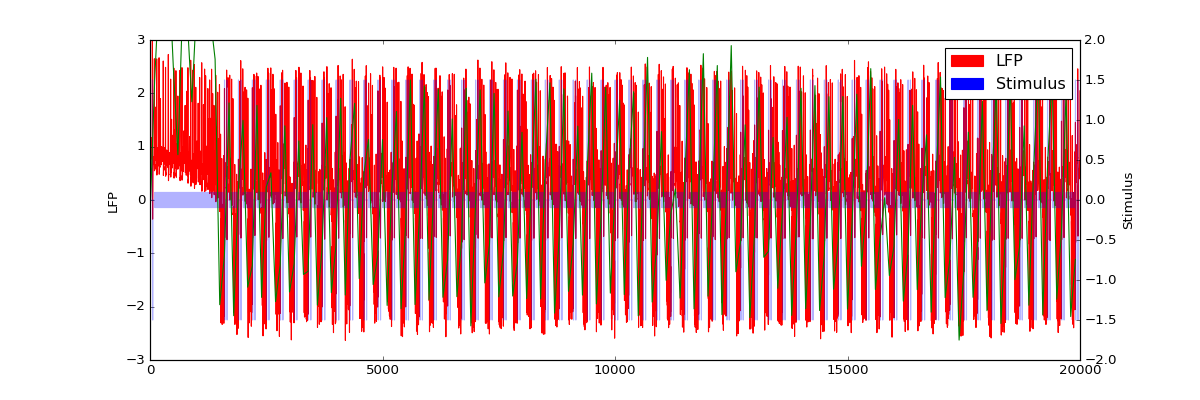

In [203]:
fig, ax1 = pyplot.subplots(figsize=(15,5))
ax2 = ax1.twinx()

ax1.set_ylim(-3, 3)
ax1.set_ylabel('LFP')
ax2.set_ylim(-2, 2)
ax2.set_ylabel('Stimulus')

ax2.plot(amps_all, 'b', alpha = 0.3)
ax1.plot(d_all[ic_buffer:,0,9,0], 'r')
ax2.plot(len_frame * np.array(range(len(rewards_all))), rewards_all, 'g')



red = matplotlib.patches.Patch(color='red', label = 'LFP')
blue = matplotlib.patches.Patch(color='blue', label = 'Stimulus')
legend(handles=[red,blue])
show()

In [211]:
def softmax(state, tau_s = 0.2):
    
    tops = {}
    probs = []
    
    for a in actions:
        num = np.exp( q_table.get((state,a), -5) / tau_s )
        tops[a] = num
        
    denom = 0.0
    for x in tops: denom += float(tops[x])
        
    for a in actions:
        probs.append( tops[a] / denom)
        
    rand = random.random()
    
    p = 0
    for i in range(len(probs)):
        p += probs[i]
        if rand <= p:
            return actions[i]
        
            
    

In [286]:
softmax((1,))

('sin', 0.3, 25, True)

#Choosing A Reward Function
Testing different frequency bands to pick the best-looking reward

In [41]:
los = [0.0,0.1,0.2,0.3,0.4]
his = [0.1,0.2,0.3,0.4,0.5]
ords = [3,4,5]
path = "rewardtest/"
ioff()
for n in range(len(data_all)):
    
    #print "testing " + str(n)
    
    for order in ords:  
        for lo in los:
            for hi in his:
                if hi > lo:
                    
                    print "    " + str(order) + " " + str(lo) + " " + str(hi)
                    
                    states, acts, rews = trial_to_states(data_all[n][1][:,0,9,0], data_all[n][3], alpha = 0.7,
                                                        l = lo, h = hi, ordr = order)

                    fig1, ax1 = pyplot.subplots(figsize = (10,5))
                    ax2 = twinx(ax1)
                    ax2.plot(data_all[n][1][:,0,9,0], alpha = 0.5)
                    ax2.plot(100*np.array(range(100)), states, 'b', alpha = 1)
                    #ax1.plot(acts, 'g', alpha = 0.8)
                    ax1.plot(100*np.array(range(100)),np.array(rews) , 'r')
                    
                    mini = min(rews)
                    maxi = max(rews)
                    if maxi < 3:
                        maxi = 3
                    if mini > -3:
                        mini = -3
                    
                    ax1.set_ylim(mini,maxi)
                    #ax1.set_xlim(0,100)
                    ax2.set_ylim(-3,3)
                    
                    title(str(data_all[n][1][3]) + "\n lo: " + str(lo) + " hi: " + str(hi) + " ord: " + str(order))
                    fig1.savefig(path + str(n) + "-lo" + str(int(10*lo)) + "-hi" + str(int(10*hi)) + "-ord" + str(order))

#Epileptor Functions


In [90]:
def run_frame(sim, stim, action_amps):
    for i in range(n_frame):
       
            
            
            
        #params_dict = {'amp' : action_amps[i], 'T' : dt, 'tau' : dt, 'onset' : dt}

        stim.temporal.parameters["amp"] = action_amps[i]
        #stim.temporal.parameters["T"] = runtime
        #stim.temporal.parameters["tau"] = runtime
        
        (t, d), (te, de), (ti, di) = sim.run(simulation_length = dt)
        
        
        if i == 0:
            t_f = copy.deepcopy(t)
            d_f = copy.deepcopy(d)
            
        else: 
            t_f = np.append(t_f, t, axis = 0)
            d_f = np.append(d_f, d, axis = 0)
    
    return t_f, d_f

def prepare_sim(): 
    epileptic = [9]
    almost_epileptic = []
    stimulus_target = [9]
    stimulus_amplitude = 0
    stimulus_weight = 2 #0-2 for each region
    onset = 0
    period = runtime
    pulse_width = runtime
    frame_length = len_frame
    (s, stimulus) = set_sim(epileptic, almost_epileptic, stimulus_target, stimulus_amplitude, 
                  stimulus_weight, onset, period, pulse_width, runtime)


    (t_t, t_d), (aa, aa1), (bb, bb1) = s.run(simulation_length = ic_buffer)

    t_all = copy.copy(t_t)
    d_all = copy.copy(t_d)

    return t_all, d_all, s, stimulus

def set_sim(epileptic, almost_epileptic, target, amp, stim_weight, 
            onset, period, pw, sim_time, K_s=-0.2, K_f=0.1, r_1=0.00015):
  
    #Set up epileptic regions
    epileptors = models.Epileptor(Ks=K_s, Kf=K_f, r=r_1)
    epileptors.x0 = np.ones((76))*-2.4 #set all brain regions non-epileptic
    epileptors.x0[almost_epileptic] = np.ones((2))*-1.9 #overwrite as epileptogenic; borderline epileptic ('close to epilepsy threshold')
    epileptors.x0[epileptic] = np.ones((3))*-1.6 #rHC and lHC are epileptic

    #brain parameters and integration method
    con = connectivity.Connectivity(load_default=True)
    coupl = coupling.Difference(a=1.)
   


    hiss = noise.Additive(nsig = np.array([0., 0., 0., 0.0003, 0.0003, 0.]))
    #heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)
    heunint = integrators.HeunDeterministic(dt=0.05)

    #set up monitors (SEEG and temporal average)
    rm = region_mapping.RegionMapping(load_default=True)
    mon_tavg = monitors.TemporalAverage(period=1.)
    mon_EEG = monitors.EEG(load_default=True,
                       region_mapping=rm,
                       period=1.)
    mon_SEEG = monitors.iEEG(load_default=True,
                             region_mapping=rm,
                             period=1.,
                             ) #intracranial EEG (iEEG) is a particular/specific type of stereoEEG (SEEG)
    what_to_watch = (mon_tavg, mon_EEG, mon_SEEG)
    
    
    #set stimulus to epileptic regions
    weighting = np.ones((76))*0 #np.zeros((76))
    weighting[target] = np.array([stim_weight]) #stimulate rHC and lHC


    #set stimulation paramaeters
    eqn_t = equations.PulseTrain()               #square wave
    eqn_t.parameters["T"] = period             #period
    eqn_t.parameters["onset"] = onset
    eqn_t.parameters["tau"] = pw 
    eqn_t.parameters["amp"] = amp
    stim = patterns.StimuliRegion(temporal = eqn_t,
                          connectivity = con, 
                          weight = weighting)
    
    #Configure space and time
    stim.configure_space()
    stim.configure_time(np.arange(0., sim_time, heunint.dt))

    #Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
    sim = simulator.Simulator(model = epileptors, 
                      connectivity = con,
                      coupling = coupl, 
                      integrator = heunint, 
                      monitors = what_to_watch,
                      stimulus = stim,
                      simulation_length = sim_time)
    sim.configure()
    #plot_pattern(stim)
    return (sim, stim)

#Actions

In [82]:
def translate_action(action):
    
    if (len(action)) > 3:
        balance_charge = action[3]
    action_amps = []
    
    if action[0] == 'sin':
        wave_amp = action[1]
        period = action[2]        
        for i in range(n_frame):
            action_amps.append( wave_amp * np.sin( (2*np.pi / period) * i ))
        if balance_charge:
            action_amps[n_frame - 1] -= sum(action_amps)
    
    elif action[0] == 'sqr':
        wave_amp = action[1]
        period = action[2]
        pulse_width = action[4]
        for i in range(n_frame):
            if (i*dt) % period  == 0:
                amplitude = wave_amp
                
            elif (i*dt - pulse_width/2) % period == 0:
                amplitude = -wave_amp
            
            elif (i*dt - pulse_width) % period == 0:
                amplitude = 0
                
            action_amps.append(amplitude)
       
    elif action[0] == 'non':
        for i in range(n_frame):
            action_amps.append(0)
    

    
    return action_amps

In [152]:
q_table = make_qtable(all_tuples)
random.shuffle(all_tuples)
q_2 = make_qtable(all_tuples)

In [155]:
q_2

{((-1,), ('non',)): -2.4677967784877026,
 ((-1,), ('sin', 0.1, 5, True)): -1.2146629420544126,
 ((-1,), ('sin', 0.1, 10, True)): -1.6395523530852583,
 ((-1,), ('sin', 0.1, 25, True)): -1.282979518708421,
 ((-1,), ('sin', 0.2, 25, True)): -1.7557616224926114,
 ((-1,), ('sin', 0.25, 5, True)): -1.8097000220347947,
 ((-1,), ('sin', 0.25, 10, True)): -1.7076725957938514,
 ((-1,), ('sin', 0.3, 25, True)): -1.5928027054021556,
 ((-1,), ('sin', 0.4, 25, True)): -1.2094070997080966,
 ((-1,), ('sin', 0.5, 5, True)): -1.641022775340603,
 ((-1,), ('sin', 0.5, 10, True)): -1.6745571785629063,
 ((-1,), ('sin', 0.5, 25, True)): -0.46434718851749873,
 ((-1,), ('sin', 0.5, 50, True)): -0.77276193614938615,
 ((-1,), ('sin', 1.0, 5, True)): -1.6538304072877668,
 ((-1,), ('sin', 1.0, 10, True)): -1.6216042794018812,
 ((-1,), ('sin', 1.0, 25, True)): -0.54657624875184085,
 ((-1,), ('sin', 1.0, 50, True)): -0.77457390792297331,
 ((-1,), ('sin', 1.5, 25, True)): -0.48574495139095386,
 ((-1,), ('sin', 1.5, 5